## Imports

In [34]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import wkt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from transformers import pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Data Load/Clean

In [35]:
crime_df = pd.read_csv('data/Police_Department_Incident_Reports__Historical_2016_to_May_2018.csv')
crime_df.head()

PdId  IncidntNum  Incident Code       Category  \
0  16072741510045   160727415          10045   EMBEZZLEMENT   
1  16600299606372   166002996           6372  LARCENY/THEFT   
2  17015398506304   170153985           6304  LARCENY/THEFT   
3  16063185010015   160631850          10015   EMBEZZLEMENT   
4  16020260575030   160202605          75030   NON-CRIMINAL   

                                Descript DayOfWeek        Date   Time  \
0  EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE    Friday  01/01/2016  00:01   
1                PETTY THEFT OF PROPERTY    Friday  01/01/2016  13:40   
2            GRAND THEFT FROM A BUILDING    Friday  01/01/2016  00:01   
3              EMBEZZLEMENT, GRAND THEFT    Friday  01/01/2016  12:00   
4                           CASE CLOSURE    Friday  01/01/2016  12:00   

  PdDistrict Resolution                   Address           X          Y  \
0  INGLESIDE       NONE  5700 Block of MISSION ST -122.450297  37.709552   
1    CENTRAL       NONE   JEFFERSON ST / MASON ST -122.414167  37.808420   
2    BAYVIEW       NONE    100 Block of APOLLO ST -122.398745  37.730854   
3    BAYVIEW       NONE      4000 Block of 3RD ST -122.388753  37.740736   
4    CENTRAL  UNFOUNDED     2700 Block of HYDE ST -122.420535  37.806189   

                                         location  
0   POINT (-122.45029719777277 37.70955194084215)  
1  POINT (-122.41416651509333 37.808419917270975)  
2   POINT (-122.3987447553861 37.730854021807374)  
3   POINT (-122.38875304699722 37.74073605483584)  
4     POINT (-122.4205346782714 37.8061892244521)

In [36]:
# crime_df['Date'] = pd.to_datetime(crime_df['Date'])

In [37]:
crime_df.dtypes

PdId               int64
IncidntNum         int64
Incident Code      int64
Category          object
Descript          object
DayOfWeek         object
Date              object
Time              object
PdDistrict        object
Resolution        object
Address           object
X                float64
Y                float64
location          object
dtype: object

In [38]:
crime_df = crime_df.drop(columns=['PdId', 'IncidntNum', 'Incident Code', 'Address', 'location'])

In [39]:
crime_df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict',
       'Resolution', 'X', 'Y'],
      dtype='object')

In [40]:
crime_df.shape

(345979, 9)

In [41]:
neighb_df = pd.read_csv('data/sf_neighbourhoods.csv')

In [42]:
neighb_df.head()

LINK  \
0  http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                NaN   
2                  http://www.nps.gov/prsf/index.htm   
3                                                NaN   
4  http://www.sfgate.com/neighborhoods/sf/innerri...   

                                            the_geom                    name  
0  MULTIPOLYGON (((-122.49345526799993 37.7835181...                Seacliff  
1  MULTIPOLYGON (((-122.48715071499993 37.7837854...             Lake Street  
2  MULTIPOLYGON (((-122.47758017099994 37.8109931...  Presidio National Park  
3  MULTIPOLYGON (((-122.47241052999993 37.7873465...        Presidio Terrace  
4  MULTIPOLYGON (((-122.47262578999994 37.7863148...          Inner Richmond

In [43]:
neighb_df.shape

(117, 3)

## Geo Coordinates Classification

In [44]:
geom = [Point(xy) for xy in zip(crime_df['X'], crime_df['Y'])]
crime_geo = gpd.GeoDataFrame(crime_df, geometry=geom)
crime_geo.head()

Category                               Descript DayOfWeek        Date  \
0   EMBEZZLEMENT  EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE    Friday  01/01/2016   
1  LARCENY/THEFT                PETTY THEFT OF PROPERTY    Friday  01/01/2016   
2  LARCENY/THEFT            GRAND THEFT FROM A BUILDING    Friday  01/01/2016   
3   EMBEZZLEMENT              EMBEZZLEMENT, GRAND THEFT    Friday  01/01/2016   
4   NON-CRIMINAL                           CASE CLOSURE    Friday  01/01/2016   

    Time PdDistrict Resolution           X          Y  \
0  00:01  INGLESIDE       NONE -122.450297  37.709552   
1  13:40    CENTRAL       NONE -122.414167  37.808420   
2  00:01    BAYVIEW       NONE -122.398745  37.730854   
3  12:00    BAYVIEW       NONE -122.388753  37.740736   
4  12:00    CENTRAL  UNFOUNDED -122.420535  37.806189   

                      geometry  
0  POINT (-122.45030 37.70955)  
1  POINT (-122.41417 37.80842)  
2  POINT (-122.39874 37.73085)  
3  POINT (-122.38875 37.74074)  
4  POINT (-122.42053 37.80619)

In [45]:
neighb_df['geometry'] = neighb_df['the_geom'].apply(wkt.loads)
neighb_geo = gpd.GeoDataFrame(neighb_df)
neighb_geo.head(2)

LINK  \
0  http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...   
1                                                NaN   

                                            the_geom         name  \
0  MULTIPOLYGON (((-122.49345526799993 37.7835181...     Seacliff   
1  MULTIPOLYGON (((-122.48715071499993 37.7837854...  Lake Street   

                                            geometry  
0  MULTIPOLYGON (((-122.49346 37.78352, -122.4937...  
1  MULTIPOLYGON (((-122.48715 37.78379, -122.4872...

In [46]:
crime_geo['neighbourhood'] = None

In [47]:
crime_geo.head(2)

Category                               Descript DayOfWeek        Date  \
0   EMBEZZLEMENT  EMBEZZLEMENT, GRAND THEFT BY EMPLOYEE    Friday  01/01/2016   
1  LARCENY/THEFT                PETTY THEFT OF PROPERTY    Friday  01/01/2016   

    Time PdDistrict Resolution           X          Y  \
0  00:01  INGLESIDE       NONE -122.450297  37.709552   
1  13:40    CENTRAL       NONE -122.414167  37.808420   

                      geometry neighbourhood  
0  POINT (-122.45030 37.70955)          None  
1  POINT (-122.41417 37.80842)          None

In [48]:
crime_geo.loc[crime_geo.intersects(neighb_geo.loc[0, 'geometry']), 'neighbourhood'] = neighb_geo['name'].loc[0]

In [49]:
%%time
for i in range(len(neighb_geo)):
    crime_geo.loc[crime_geo.intersects(neighb_geo.loc[i, 'geometry']), 'neighbourhood'] = neighb_geo['name'].loc[i]

CPU times: user 2min 38s, sys: 1.78 s, total: 2min 40s
Wall time: 2min 49s


In [50]:
crime_geo['neighbourhood'].isna().sum() / len(crime_geo) #The percentage of missing data is minimal, so it is okay to drop it

0.002601313952580937

In [51]:
crime_geo.dropna(inplace=True)

## Feature Engineering

In [52]:
crime_geo['Date'] = pd.to_datetime(crime_geo['Date'])
crime_geo['Time'] = pd.to_datetime(crime_geo['Time'])
crime_geo['Month'] = crime_geo['Date'].dt.month
crime_geo['Day'] = crime_geo['Date'].dt.day
crime_geo['Year'] = crime_geo['Date'].dt.year
crime_geo['Hour'] = crime_geo['Time'].dt.hour

# Converting year to a string as to not skew the modeling
crime_geo['Year'] = crime_geo['Year'].astype(str)

In [53]:
crime_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 345079 entries, 0 to 345978
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Category       345079 non-null  object        
 1   Descript       345079 non-null  object        
 2   DayOfWeek      345079 non-null  object        
 3   Date           345079 non-null  datetime64[ns]
 4   Time           345079 non-null  datetime64[ns]
 5   PdDistrict     345079 non-null  object        
 6   Resolution     345079 non-null  object        
 7   X              345079 non-null  float64       
 8   Y              345079 non-null  float64       
 9   geometry       345079 non-null  geometry      
 10  neighbourhood  345079 non-null  object        
 11  Month          345079 non-null  int64         
 12  Day            345079 non-null  int64         
 13  Year           345079 non-null  object        
 14  Hour           345079 non-null  int64       

Breaking the hours down into periods of a day for more interpretability during EDA.

In [54]:
# Parts of day split between ranges below:
#     morning = 6am - 11:59pm (6,11)
#     aftrenoon = 12pm - 5:59pm (12, 17)
#     evening = 6pm - 10:59pm (18, 22)
#     overnight = 11pm - 5:59am (0, 5)

crime_geo['Morning'] = crime_geo['Time'].dt.hour.between(6, 11).astype(int)
crime_geo['Afternoon'] = crime_geo['Time'].dt.hour.between(12, 17).astype(int)
crime_geo['Evening'] = crime_geo['Time'].dt.hour.between(18, 22).astype(int)
crime_geo['Overnight'] = (
    (crime_geo['Time'].dt.hour == 23) | \
    (crime_geo['Time'].dt.hour.between(0, 5)) \
    ).astype(int)

In [55]:
# Drop columns due to multicollinearity
crime_geo.drop(columns='Date', inplace=True)
crime_geo.drop(columns='Time', inplace=True)

The `TREA` category only had 4 occurences, or 0.0012% of the total data, so we will go ahead and remove it from the data set due to insignificance.

In [56]:
# Drop row containing the category 'TREA' as there are only four occurences, or 0.0012% of total data.
crime_geo = crime_geo[crime_geo['Category'] != 'TREA']

After looking into the descriptions of the arrests, we found the `OTHER OFFENSES` & `RECOVERED VEHICLE` had little relevance to our problem statement. For instance, the `OTHER OFFESNSES` category contained several occurences of speeding tickets, while the`RECOVERED VEHICLE` category pertained to finding lost vehicles. For this reason, we opted to omit these categories from our analysis.

In [57]:
# Drop rows where 'Category' is 'Other Offenses' or 'Recovered Vehicle'
crime_geo = crime_geo[(crime_geo["Category"] != 'OTHER OFFENSES')]
crime_geo = crime_geo[(crime_geo["Category"] != 'RECOVERED VEHICLE')]

Preliminary modeling showed poor results for classifying models on thirty-eight categories. We decided to group the categories into a total of three parent categories:
- Police: Urgent
- Police: Non-urgent
- Other: Police may still be needed, but priority shall be given to other specialty personel for first responders

The below code will map our parent categories onto a `Target` column in our data frame.

In [58]:
# Defining target categories
target = {
    'specialty_support': ['SUICIDE', 'DISORDERLY CONDUCT', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'FRAUD', 'EMBEZZLEMENT',
             'BRIBERY', 'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'FORGERY/COUNTERFEITING', 'KIDNAPPING',
             'SEX OFFENSES, NON FORCIBLE', 'SEX OFFENSES, FORCIBLE', 'FAMILY OFFENSES', 'SECONDARY CODES',
             'NON-CRIMINAL'],
    'police': ['PROSTITUTION', 'ASSAULT', 'ARSON', 'WEAPON LAWS', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY'],
    'police_non_urgent': ['LARCENY/THEFT', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'SUSPICIOUS OCC',
                         'VANDALISM', 'PORNOGRAPHY/OBSCENE MAT', 'LOITERING', 'MISSING PERSON',
                         'BURGLARY', 'TRESPASS', 'WARRANTS',  'LIQUOR LAWS']
}

# Mapping 'Target' column from 'Categories' column
#
# The code below was taken from user ALollz's response to question at the following link:
# https://stackoverflow.com/questions/64320960/pandas-create-a-column-by-mapping-from-a-dict-of-lists

target_map = {val:key for key, lst in target.items() for val in lst}
crime_geo['Target'] = crime_geo['Category'].map(target_map)

# Changing 'Target' column to 'other' where 'Category' is 'Prostitution' AND 'Descript' contains any of
#     the following words: ['trafficking', 'pimping', 'underage']
#
# Inspiration for the following code was taken from user cs95's response to the question at the link below:
# https://stackoverflow.com/questions/47937697/scalable-solution-for-str-contains-with-list-of-strings-in-pandas

prostitution_flags = ['trafficking', 'pimping', 'underage']
flag = '|'.join(prostitution_flags)
mask = crime_geo.loc[:, ('Descript')].str.lower().str.contains(flag)
crime_geo.at[mask,'Target'] = 'specialty_support'

# Changing 'Target' column to 'police_non_urgent' where 'Category' is 'PROSTITUTION' AND 'DESCRIPT' contains any of
#     the following words: ['civil', 'investigation']
non_crim_flags = ['civil', 'investigation']
flag = '|'.join(non_crim_flags)
mask = crime_geo.loc[:, ('Descript')].str.lower().str.contains(flag)
crime_geo.at[mask,'Target'] = 'police_non_urgent'

In [59]:
crime_geo.copy().to_csv('./data/combined_data_set.csv')

## Geo Visualisations

/Users/gcano01/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


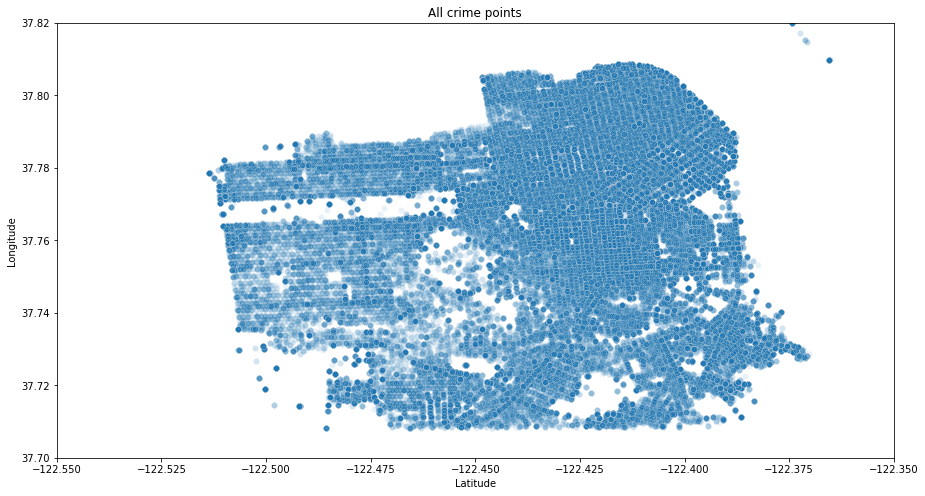

In [60]:
plt.figure(figsize = (15,8))
sns.scatterplot(crime_geo['X'], crime_geo['Y'], alpha=0.1)
plt.xlim(-122.55, -122.35)
plt.ylim(37.7, 37.82)
plt.title('All crime points')
plt.xlabel('Latitude')
plt.ylabel('Longitude');

In [61]:
neighb_coord = []
for row in neighb_geo['the_geom']:
    clean_row = row.strip('MULTIPOLYGON (((')
    clean_row = clean_row.strip(')))')
    clean_row = ' ' + clean_row # Putting everything into a uniform string to further split it into a list
    clean_row = clean_row.split(',')
    clean_row = [val.split(' ') for val in clean_row]
    for i in range(len(clean_row)):
        clean_row[i].pop(0)
    clean_row = [list(map(float, val))[::-1] for val in clean_row]
    neighb_coord.append(clean_row)

In [62]:
neighb_geo['lon_lat'] = neighb_coord

In [63]:
# Saturday overnight differentiate by target
sp_sup = crime_geo[(crime_geo['Target'] == 'specialty_support') & (crime_geo['Year'] == 2018) & (crime_geo['Overnight'] == 1) & (crime_geo['DayOfWeek'] == 'Saturday')]
pol = crime_geo[(crime_geo['Target'] == 'police') & (crime_geo['Year'] == 2018) & (crime_geo['Overnight'] == 1) & (crime_geo['DayOfWeek'] == 'Saturday')]
pnu = crime_geo[(crime_geo['Target'] == 'police_non_urgent') & (crime_geo['Year'] == 2018) & (crime_geo['Overnight'] == 1) & (crime_geo['DayOfWeek'] == 'Saturday')]

In [64]:
%%time
# Neighbourhood SF
sf_neighb = folium.Map(location=[37.8, -122.5])
neighb_geo.apply(lambda row:folium.Polygon(locations=[row['lon_lat']], weight=2).add_to(sf_neighb), axis=1)

sf_neighb

CPU times: user 35 ms, sys: 20.2 ms, total: 55.2 ms
Wall time: 73.6 ms


In [65]:
%%time
sf_map_1 = folium.Map(location=[37.8, -122.5])

pnu.apply(lambda row:folium.CircleMarker(location=[row['Y'], row['X']], radius=1, color='yellow').add_to(sf_map_1), axis=1)
sp_sup.apply(lambda row:folium.CircleMarker(location=[row['Y'], row['X']], radius=1, color='green').add_to(sf_map_1), axis=1)
pol.apply(lambda row:folium.CircleMarker(location=[row['Y'], row['X']], radius=1, color='red').add_to(sf_map_1), axis=1)

neighb_geo.apply(lambda row:folium.Polygon(locations=[row['lon_lat']], weight=2).add_to(sf_map_1), axis=1)

sf_map_1

CPU times: user 31.4 ms, sys: 2.58 ms, total: 34 ms
Wall time: 33.4 ms


In [66]:
%%time
sf_map_3 = folium.Map(location=[37.8, -122.5])
crime_geo[crime_geo['Category'] == 'DRUG/NARCOTIC'].apply(lambda row:folium.CircleMarker(location=[row['Y'], row['X']], radius=1, color='red').add_to(sf_map_3), axis=1)
neighb_geo.apply(lambda row:folium.Polygon(locations=[row['lon_lat']], weight=2).add_to(sf_map_3), axis=1)

sf_map_3

CPU times: user 915 ms, sys: 87.8 ms, total: 1 s
Wall time: 1.33 s
